In [234]:
import numpy as np
import sdt.sim
from matplotlib import pyplot
import tifffile
import io
import hdf5plugin

In [243]:
def simulate_image(image_size=256, beads=200, sigma=2, amp=500, zrange=12, offset=100, poisson=True):
    coords = np.random.randint(0,image_size, size=(3,beads)).T # z x y
    
    out = np.zeros(
        shape=(image_size,image_size,image_size),
        #dtype=np.uint16
    )
    
    for i in range(image_size):
        filtered_coords = []
        for x in coords:
            if i-(zrange) < x[0] < i+(zrange):
                filtered_coords.append(x)
        
        to_plot = []
        for coord in filtered_coords:
            dz = abs(coord[0] - i)
            #The below ratio is G(x) / G(0) (normalize)
            ratio = np.exp(-1 * (dz**2) / (2 * (sigma**2)))
            to_plot.append( ((coord[1], coord[2]), amp * ratio) )
        
        if len(to_plot) > 0:
            new_coords = np.array( [ [x,y] for ((x,y),_) in to_plot ] )
            new_amplitudes = np.array( [amp for _,amp in to_plot] )

            out[i,...] = sdt.sim.simulate_gauss(
                (image_size,image_size),
                new_coords,
                new_amplitudes,
                np.zeros_like(new_amplitudes)+sigma
            )[...]
    
    out += offset
    
    if poisson:
        return np.random.poisson(lam=out).astype(np.uint16)
    
    return out.astype(np.uint16)

In [244]:
%%timeit
img = simulate_image()

817 ms ± 4.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [245]:
tifffile.imwrite('stack.tif', simulate_image(beads=10000))

In [246]:
import h5py

In [247]:
def test_compression(params={}, beads=200):
    with io.BytesIO() as tmpfile:
        with h5py.File(tmpfile, 'w') as h5file:
            img = simulate_image(beads=beads)
            h5file.create_dataset("data", data=img, **params, chunks=(32,32,32)) #compression="gzip", compression_opts=9
            return tmpfile.getbuffer().nbytes

In [248]:
test_compression(beads=200) / test_compression( params={'compression':'gzip', 'compression_opts':9} , beads=200)

2.205484702512762

In [249]:
res = [
    test_compression(beads=x) / test_compression( params={'compression':'gzip', 'compression_opts':9} , beads=x)
    for x in [1, 10, 100, 1000, 10000]
]

In [250]:
res

[2.2291976699717835,
 2.228095817854822,
 2.2170220271202945,
 2.1301338361013222,
 1.774219955425798]

In [257]:
res2 = [
    test_compression(beads=x) / test_compression( params=hdf5plugin.Blosc(cname='zstd', clevel=9, shuffle=hdf5plugin.Blosc.BITSHUFFLE) , beads=x)
    for x in [1, 10, 100, 1000, 10000]
]

In [258]:
res2

[2.5973995683579196,
 2.596118883586372,
 2.5883546975860785,
 2.518310600912096,
 2.1164158818186314]

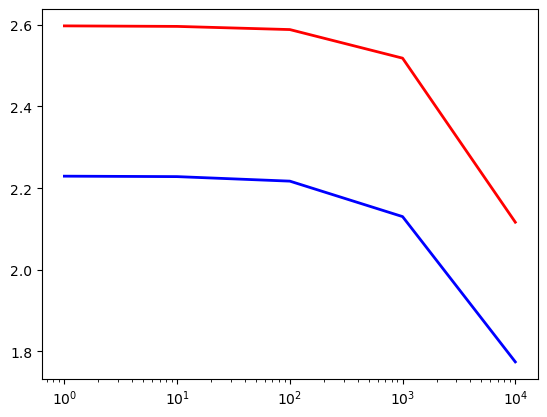

In [268]:
fig = pyplot.figure()
ax = fig.add_subplot(1, 1, 1)

x_marks = [1, 10, 100, 1000, 10000]
line, = ax.plot(x_marks, res, color='blue', lw=2)
line, = ax.plot(x_marks, res2, color='red', lw=2)

ax.set_xscale('log')